In [179]:
import numpy as np
import os
import rosbag
import matplotlib.pylab as plt
import copy
import sys
import tqdm
import time
import math
import bisect


# 関数定義

In [2]:
class HyperTransition:
    def __init__(self, t, delta_t, x, y):
        self.t = t
        self.delta_t = delta_t
        self.x = x
        self.y = y

In [3]:
def get_histogram(times, polarities, maxtime=0.01, dt=0.0001):
    histogram_pos = []
    histogram_neg = []
    n = 0
    while dt * (n+1) <= maxtime:
        histogram_pos.append(np.count_nonzero((times > dt*n) & (times < dt*(n+1)) & (polarities==1) ))
        histogram_neg.append(np.count_nonzero((times > dt*n) & (times < dt*(n+1)) & (polarities==0) ))

        n += 1
    return np.array(histogram_pos), np.array(histogram_neg)

In [8]:
def get_trans_at(event_at):
    idx_transition = np.where(event_at[:-1, 3] != event_at[1:, 3])[0]
    hyper_trans_list = []
    for idx in idx_transition:
        ht = HyperTransition(event_at[idx+1, 2], event_at[idx+1, 2] - event_at[idx, 2] ,event_at[idx, 0], event_at[idx, 1])
        hyper_trans_list.append(ht)
    return hyper_trans_list

In [86]:
def get_ht_list(event_buffer):
    ht_list = [[[] for _ in range(720)] for _ in range(1280)]
    last_event = [[None for _ in range(720)] for _ in range(1280)]

    for event in event_buffer:
        x, y, t, p = int(event[0]), int(event[1]), event[2], int(event[3])
        # Update last_event
        if last_event[x][y] is not None:
            if last_event[x][y][1] != p: # If this was a transition, then update the data
                if len(ht_list[x][y]) == 0:
                    last_t = 0
                else:
                    last_t = ht_list[x][y][-1][0]
                ht_list[x][y].append([t, t - last_t])
        last_event[x][y] = [t, p] # [time, polarity]
    return ht_list

In [80]:
def get_evidence_map(ht_list, time_len, fi, sigma=30, n=5, img_size = (1280, 720)):
    gauss = lambda x : np.exp(-x**2/2/sigma**2) / np.sqrt(2*np.pi*sigma*sigma)
    evidence_map = np.zeros(img_size).tolist()
    for x in range(img_size[0]):
        for y in range(img_size[1]):
            for ht in ht_list[x][y]:
                if time_len - n * 1.0/fi < ht[0] and ht[0] < time_len and ht[1]!=0:
                    evidence_map[x][y] += gauss(1.0/ht[1] - fi)
    return evidence_map

In [81]:
def get_estimated_pos_from_evidence_map(evidence_map, thres_rate=0.8):
    xs, ys = np.where(np.array(evidence_map) > np.max(evidence_map)*thres_rate)
    est_pos = [np.mean(xs), np.mean(ys)]
    return est_pos
#     return np.unravel_index(np.argmax(evidence_map), np.array(evidence_map).shape)

In [110]:
def estimate_led_positions_old(event_buffer, hz, window_t):
    start = time.time()
    ht_list = get_ht_list(event_buffer)
    print(time.time()-start)
    start = time.time()
    pos_est = {}
    evidence_map_dict = {}
    for fi in hz:
        evidence_map = get_evidence_map(ht_list, window_t, fi)
        estimated_pos = get_estimated_pos_from_evidence_map(evidence_map)
        pos_est[fi] = estimated_pos
        evidence_map_dict[fi] = evidence_map
    print(time.time()-start)
    start = time.time()
    return pos_est, evidence_map_dict

In [181]:
start = time.time()
index = bisect.bisect_left(event_time_list, 0.19)
print(index)
print(time.time() - start)

648467
0.000709056854248


In [213]:
def estimate_led_positions(event_buffer, hz, t_at, img_size=[1280, 720], time_list=None):
    start = time.time()
    last_event_polarity = [[-1 for _ in range(img_size[1])] for _ in range(img_size[0])]
    last_trans_time = [[0 for _ in range(img_size[1])] for _ in range(img_size[0])]
    evidence_maps = {}
    for freq in hz:
        evidence_maps[freq] = [[0 for _ in range(img_size[1])] for _ in range(img_size[0])]

    sigma = 30
    n = 5
    gauss = lambda x : math.exp(-x**2/2/sigma**2) / math.sqrt(2*math.pi*sigma*sigma)
    
    if time_list is not None:
        min_index = bisect.bisect_left(event_time_list, event_time_list[-1] - min([n * 1.0/freq for freq in hz]))

    for event in event_buffer[min_index:]:
        x, y, t, p = int(event[0]), int(event[1]), event[2], int(event[3])
        if last_event_polarity[x][y] == -1:
            last_event_polarity[x][y] = p*1
        elif last_event_polarity[x][y] != p*1:
            # Update evidence_map
            dt = t - last_trans_time[x][y] 
            for freq in hz:
                if t_at - n * 1.0/freq < t and t < t_at and dt!=0:
                    evidence_maps[freq][x][y] += gauss(1.0/dt - freq)
            last_trans_time[x][y] = t
        last_event_polarity[x][y] = p*1
    estimated_poss = {}
    for freq in hz:
        estimated_poss[freq] = get_estimated_pos_from_evidence_map(evidence_maps[freq], thres_rate=0.9)

    return estimated_poss, evidence_maps

In [217]:
def get_event_list_from_bag(bag, extract_time=0.1):
    event_list = [] # x, y, t, p
    event_time_list = [] # t

    timestamp_list = []
    start_time = -1
    for topic, msg, t in tqdm.tqdm(bag):
        if topic=='/prophesee/camera/cd_events_buffer':
            if start_time<0:
                start_time = msg.events[0].ts.to_time()
            if msg.events[0].ts.to_time() - start_time > extract_time:
                break
            for event in msg.events:
                if msg.events[0].ts.to_time() - start_time > extract_time:
                    break
                event_list.append([int(event.x), int(event.y), event.ts.to_time() - start_time, event.polarity])
                event_time_list.append(event.ts.to_time() - start_time)
    return event_list, event_time_list

In [219]:
event_list, event_time_list = get_event_list_from_bag(bag)
estimated_poss, evidence_maps = estimate_led_positions(event_list, [500, 700], 0.5, time_list=event_time_list)

6307it [00:14, 432.05it/s]


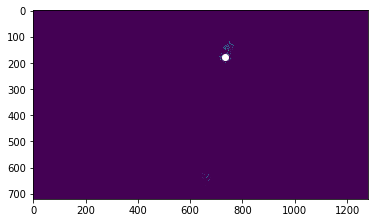

In [221]:
fi = 500
plt.imshow(np.array(evidence_maps[fi]).T)
plt.scatter(estimated_poss[fi][0], estimated_poss[fi][1], color='white')

# 暗所、500HzのLEDのみの環境で、500Hzであることを確認

In [13]:
bagpath = '/home/koji/dvs/vlc/data/led_500_700hz_light.bag'
bag = rosbag.Bag(bagpath)
! rosbag info $bagpath

path:        /home/koji/dvs/vlc/data/led_500_700hz_light.bag
version:     2.0
duration:    4.0s
start:       Aug 31 2020 17:19:27.33 (1598861967.33)
end:         Aug 31 2020 17:19:31.30 (1598861971.30)
size:        134.6 MB
messages:    38492
compression: none [179/179 chunks]
types:       dvs_msgs/EventArray    [5e8beee5a6c107e504c2e78903c224b8]
             rosgraph_msgs/Log      [acffd30cd6b6de30f120938c17c593fb]
             sensor_msgs/CameraInfo [c9a58c1b0b154e0e6da7578cb991d214]
topics:      /prophesee/camera/camera_info           19 msgs    : sensor_msgs/CameraInfo
             /prophesee/camera/cd_events_buffer   38469 msgs    : dvs_msgs/EventArray   
             /rosout                                  4 msgs    : rosgraph_msgs/Log      (2 connections)


In [201]:
event_list = [] # x, y, t, p
event_time_list = [] # t

timestamp_list = []
start_time = -1
extract_time = 0.5 #[s]
for topic, msg, t in tqdm.tqdm(bag):
    if topic=='/prophesee/camera/cd_events_buffer':
        if start_time<0:
            start_time = msg.events[0].ts.to_time()
        if msg.events[0].ts.to_time() - start_time > extract_time:
            break
        for event in msg.events:
            if msg.events[0].ts.to_time() - start_time > extract_time:
                break
            event_list.append([int(event.x), int(event.y), event.ts.to_time() - start_time, event.polarity])
            event_time_list.append(event.ts.to_time() - start_time)

6307it [00:16, 392.07it/s]


In [214]:
start = time.time()
est_poss, ev_maps = estimate_led_positions(event_list, [500, 700], 0.5, time_list = event_time_list)
end = time.time()
print(end - start)

0.423053979874


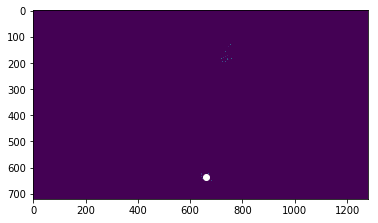

In [216]:
fi = 700
plt.imshow(np.array(ev_maps[fi]).T)
plt.scatter(est_poss[fi][0], est_poss[fi][1], color='white')

Take out events with (x, y) = (748, 321)

# Start developing algorithm

## Data Structures

In [287]:
ht_list = [[[] for _ in range(720)] for _ in range(1280)]
last_event = [[None for _ in range(720)] for _ in range(1280)]
evidence_map = np.zeros([1280, 720])

In [288]:
sorted_idx = np.argsort(event_list[:, 2])
event_list = event_list[sorted_idx].tolist()

[[552.0, 91.0, 0.0, 0.0],
 [571.0, 92.0, 0.0, 0.0],
 [558.0, 111.0, 0.0, 0.0],
 [577.0, 105.0, 0.0, 0.0],
 [571.0, 97.0, 0.0, 0.0],
 [578.0, 46.0, 1.1920928955078125e-06, 0.0],
 [581.0, 35.0, 1.1920928955078125e-06, 0.0],
 [584.0, 33.0, 1.1920928955078125e-06, 0.0],
 [579.0, 39.0, 1.1920928955078125e-06, 0.0],
 [582.0, 61.0, 1.1920928955078125e-06, 0.0],
 [570.0, 60.0, 1.1920928955078125e-06, 0.0],
 [547.0, 73.0, 1.9073486328125e-06, 0.0],
 [675.0, 176.0, 1.9073486328125e-06, 1.0],
 [1120.0, 689.0, 1.9073486328125e-06, 0.0],
 [1116.0, 679.0, 1.9073486328125e-06, 0.0],
 [1072.0, 397.0, 1.9073486328125e-06, 1.0],
 [562.0, 66.0, 2.86102294921875e-06, 0.0],
 [566.0, 68.0, 2.86102294921875e-06, 0.0],
 [554.0, 70.0, 2.86102294921875e-06, 0.0],
 [566.0, 70.0, 2.86102294921875e-06, 0.0],
 [572.0, 82.0, 2.86102294921875e-06, 0.0],
 [539.0, 106.0, 3.814697265625e-06, 0.0],
 [560.0, 114.0, 3.814697265625e-06, 0.0],
 [582.0, 96.0, 3.814697265625e-06, 0.0],
 [580.0, 81.0, 3.814697265625e-06, 0.0],


In [290]:
for event in event_list:
    x, y, t, p = int(event[0]), int(event[1]), event[2], int(event[3])
    # Update last_event
    if last_event[x][y] is not None:
        if last_event[x][y][1] != p: # If this was a transition, then update the data
            if len(ht_list[x][y]) == 0:
                last_t = 0
            else:
                last_t = ht_list[x][y][-1][0]
            ht_list[x][y].append([t, t - last_t])
    last_event[x][y] = [t, p] # [time, polarity]

In [238]:
sigma = 30
gauss = lambda x : np.exp(-x**2/2/sigma**2) / np.sqrt(2*np.pi*sigma*sigma)

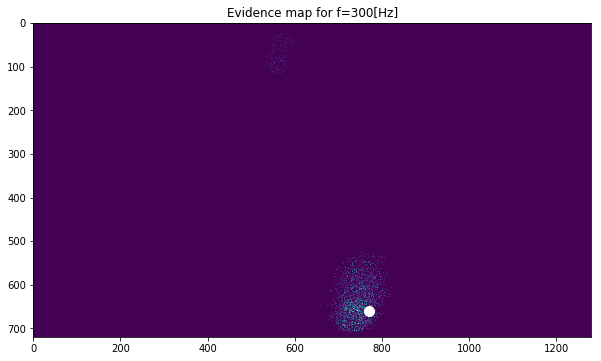

Estimated LED position is (x, y) = (770, 660)


In [278]:
t_at = 0.5
fi = 300
n = 10
evidence_map = np.zeros([1280, 720])
for x in range(1280):
    for y in range(720):
        for ht in ht_list[x][y]:
            if t_at - n * 1.0/fi < ht[0] and ht[0] < t_at and ht[1]!=0:
                evidence_map[x][y] += gauss(1.0/ht[1] - fi)
plt.figure(figsize=(10, 6))
plt.imshow(evidence_map.T)
estimated_pos = np.unravel_index(np.argmax(evidence_map), evidence_map.shape)
plt.scatter(estimated_pos[0], estimated_pos[1],  color='white', marker='o', s=100)
plt.title('Evidence map for f={}[Hz]'.format(fi))
plt.show()

print('Estimated LED position is (x, y) = ({0}, {1})'.format(estimated_pos[0], estimated_pos[1]))

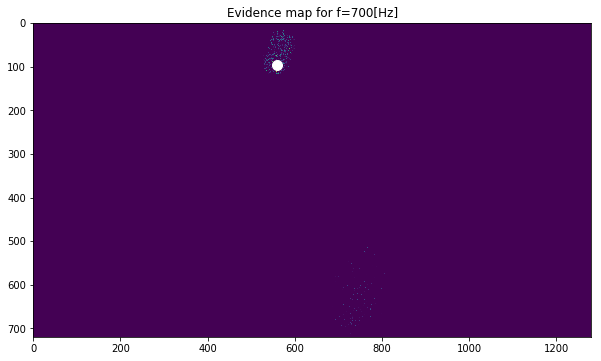

Estimated LED position is (x, y) = (559, 97)


In [279]:
t_at = 0.3
fi = 700
n = 10

evidence_map = np.zeros([1280, 720])
for x in range(1280):
    for y in range(720):
        for ht in ht_list[x][y]:
            if t_at - n * 1.0/fi < ht[0] and ht[0] < t_at and ht[1]!=0:
                evidence_map[x][y] += gauss(1.0/ht[1] - fi)
# evidence_map = evidence_map / (np.array(length)+1)

plt.figure(figsize=(10, 6))
plt.imshow(evidence_map.T)
estimated_pos = np.unravel_index(np.argmax(evidence_map), evidence_map.shape)
plt.scatter(estimated_pos[0], estimated_pos[1],  color='white', marker='o', s=100)
plt.title('Evidence map for f={}[Hz]'.format(fi))
plt.show()

print('Estimated LED position is (x, y) = ({0}, {1})'.format(estimated_pos[0], estimated_pos[1]))

## Distribution at LED@700Hz

(775.2738759922692, 638.2832931500348)
@300Hz: 0.0174290185805
@700Hz: 0.420852024162


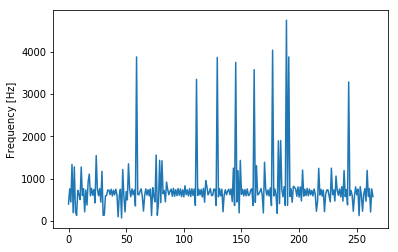

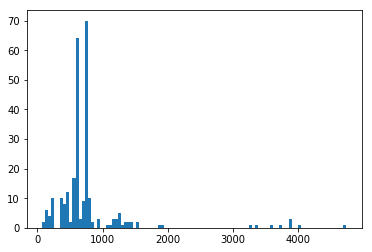

In [281]:
pos = [569, 86]
t_inv = 1/np.array(ht_list[pos[0]][pos[1]])[:, 1]
plt.plot(t_inv)
plt.ylabel('Frequency [Hz]')
plt.figure()
plt.hist(t_inv,bins=100)
print(t_inv.mean(), t_inv.std())
print('@300Hz: {}'.format(gauss(t_inv - 300).sum()))
print('@700Hz: {}'.format(gauss(t_inv - 700).sum()))

## Distribution at LED@300Hz

(280.92564031051876, 132.0074219356158)
@300Hz: 0.458751495082
@700Hz: 0.0139201533612


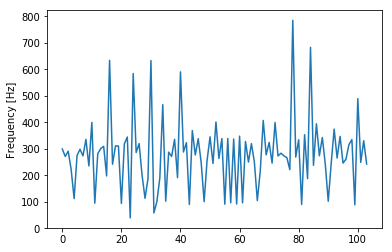

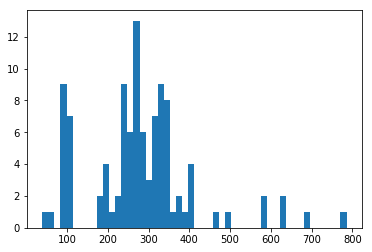

In [267]:
pos = [750, 650]
t_inv = 1/np.array(ht_list[pos[0]][pos[1]])[:, 1]
plt.plot(t_inv)
plt.ylabel('Frequency [Hz]')
plt.figure()
plt.hist(t_inv,bins=50)
print(t_inv.mean(), t_inv.std())
print('@300Hz: {}'.format(gauss(t_inv - 300).sum()))
print('@700Hz: {}'.format(gauss(t_inv - 700).sum()))

In [ ]:
test = np.array(ht_list[750][650])[:, 1]
plt.hist(test[test>0], bins=200)
plt.show()
print(len(ht_list[750][650]))

# Analyze for the whole data

In [353]:
def estimate_led_positions(event_buffer, hz, window_t):
    ht_list = [[[] for _ in range(720)] for _ in range(1280)]
    last_event = [[None for _ in range(720)] for _ in range(1280)]
    
    event_buffer = np.array(event_buffer)
    sorted_idx = np.argsort(event_buffer[:, 2])
    event_buffer = event_buffer[sorted_idx].tolist()
    
    for event in event_buffer:
        x, y, t, p = int(event[0]), int(event[1]), event[2], int(event[3])
        # Update last_event
        if last_event[x][y] is not None:
            if last_event[x][y][1] != p: # If this was a transition, then update the data
                if len(ht_list[x][y]) == 0:
                    last_t = 0
                else:
                    last_t = ht_list[x][y][-1][0]
                ht_list[x][y].append([t, t - last_t])
        last_event[x][y] = [t, p] # [time, polarity]
        
    sigma = 30
    n = 5
    gauss = lambda x : np.exp(-x**2/2/sigma**2) / np.sqrt(2*np.pi*sigma*sigma)
    pos_est_list = {}
    for fi in hz:
        evidence_map = np.zeros([1280, 720]).tolist()
        for x in range(1280):
            for y in range(720):
                for ht in ht_list[x][y]:
                    if window_t - n * 1.0/fi < ht[0] and ht[0] < window_t and ht[1]!=0:
                        evidence_map[x][y] += gauss(1.0/ht[1] - fi)
        estimated_pos = np.unravel_index(np.argmax(evidence_map), np.array(evidence_map).shape)
        pos_est_list[fi] = estimated_pos
    return pos_est_list

In [354]:
bagpath = '/home/koji/dvs/vlc/data/led_500_700hz_light.bag'
bag = rosbag.Bag(bagpath)
! rosbag info $bagpath

path:        /home/koji/dvs/vlc/data/led_500_700hz_light.bag
version:     2.0
duration:    4.0s
start:       Aug 31 2020 17:19:27.33 (1598861967.33)
end:         Aug 31 2020 17:19:31.30 (1598861971.30)
size:        134.6 MB
messages:    38492
compression: none [179/179 chunks]
types:       dvs_msgs/EventArray    [5e8beee5a6c107e504c2e78903c224b8]
             rosgraph_msgs/Log      [acffd30cd6b6de30f120938c17c593fb]
             sensor_msgs/CameraInfo [c9a58c1b0b154e0e6da7578cb991d214]
topics:      /prophesee/camera/camera_info           19 msgs    : sensor_msgs/CameraInfo
             /prophesee/camera/cd_events_buffer   38469 msgs    : dvs_msgs/EventArray   
             /rosout                                  4 msgs    : rosgraph_msgs/Log      (2 connections)


In [355]:
event_buffer = [] # x, y, t, p
timestamp_list = []
start_time = -1

window = 0.5
last_t = 0
start_t = -1

estimated_list = []

for topic, msg, t in tqdm.tqdm(bag):
    if topic=='/prophesee/camera/cd_events_buffer':        
        # Only for the first loop
        if start_t < 0:
            start_t = msg.events[0].ts.to_time()
            
        curr_time = msg.events[0].ts.to_time() - start_t
            
        # Execute pos estimation after waiting for x seconds.
        if curr_time > last_t + window:
            pos_est = estimate_led_positions(event_buffer, hz=[500, 700], window_t = window)
            estimated_list.append(pos_est)
            event_buffer = []
            last_t = msg.events[0].ts.to_time() - start_t 
            
        # Add events to event_list
        for event in msg.events:
            event_buffer.append([event.x, event.y, event.ts.to_time() - last_t - start_t, event.polarity])

16569it [00:58, 281.25it/s]


KeyboardInterrupt: 

In [356]:
estimated_list

[{500: (721, 171), 700: (662, 636)}, {500: (741, 137), 700: (656, 624)}]